In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,initializers
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import os
from tensorflow.keras import optimizers
from PIL import Image
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [3]:
def augment(imgarray):
  fliplist=[]
  for img in imgarray:
    mirror=np.flip(img,axis=1)
    fliplist.append(mirror)
  imgarray.extend(fliplist)
  return imgarray

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def rescale(img):
  imresize=img.resize((128,128))
  return imresize

In [6]:
def changedim(arr):
  fg=np.where(arr>0,1,0)
  bg=np.where(arr>0,0,1)
  out=np.stack((fg,bg),axis=2)
  return out

In [7]:
def formimg(arr):
  fg=arr[:,:,0]
  bg=arr[:,:,1]
  img=np.where(fg>bg,1,0)
  return img

In [8]:
path=os.getcwd()+'/drive/MyDrive'
path1=path+'/test/'
filelist=[]
for filename in os.listdir(path1):
    filelist.append(filename)

In [9]:
path2=path+'/Output/'
path1=path+'/test/'
image=[]
mask=[]
n=len(filelist)
for i in range(0,n):
    print(i+1)
    filepath=path1+filelist[i]
    im=(Image.open(filepath)).convert('RGB')
    im=rescale(im)
    image.append((np.asarray(im))/255)
    filepath=path2+filelist[i]
    im=(Image.open(filepath)).convert('L')
    im=rescale(im)
    arr=(np.asarray(im))/255
    mask.append(changedim(arr))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [10]:
image=augment(image)
mask=augment(mask)

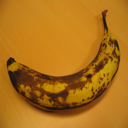

In [11]:
img1=Image.fromarray((image[1]*255).astype('uint8'), 'RGB')
img1

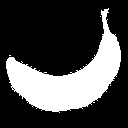

In [12]:
img2=Image.fromarray((formimg(mask[1])*255).astype('uint8'),'L')
img2

In [ ]:
def model():
  input=layers.Input(shape=(128,128,3))
  initializer=initializers.HeNormal()

  #downsampling
  #layer 1
  a1=layers.Conv2D(64,3,padding='same',activation='relu',kernel_initializer=initializer)(input)
  a2=layers.Conv2D(64,3,padding='same',activation='relu',kernel_initializer=initializer)(a1)
  p1=layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(a2)
  #layer 2
  b1=layers.Conv2D(128,3,padding='same',activation='relu',kernel_initializer=initializer)(p1)
  b2=layers.Conv2D(128,3,padding='same',activation='relu',kernel_initializer=initializer)(b1)
  p2=layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(b2)
  #layer 3
  c1=layers.Conv2D(256,3,padding='same',activation='relu',kernel_initializer=initializer)(p2)
  c2=layers.Conv2D(256,3,padding='same',activation='relu',kernel_initializer=initializer)(c1)
  p3=layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(c2)
  #layer 4
  d1=layers.Conv2D(512,3,padding='same',activation='relu',kernel_initializer=initializer)(p3)
  d2=layers.Conv2D(512,3,padding='same',activation='relu',kernel_initializer=initializer)(d1)
  p4=layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(d2)

  #bottleneck layer
  #layer 5
  e1=layers.Conv2D(1024,3,padding='same',activation='relu',kernel_initializer=initializer)(p4)
  e2=layers.Conv2D(1024,3,padding='same',activation='relu',kernel_initializer=initializer)(e1)

  #upsampling
  #layer 6
  u1=layers.Conv2DTranspose(512,(2,2),strides=2)(e2)
  f1=layers.concatenate([u1,d2])
  f2=layers.Conv2D(512,3,padding='same',activation='relu',kernel_initializer=initializer)(f1)
  f3=layers.Conv2D(512,3,padding='same',activation='relu',kernel_initializer=initializer)(f2)
  #layer 7
  u2=layers.Conv2DTranspose(256,(2,2),strides=2)(f3)
  g1=layers.concatenate([u2,c2])
  g2=layers.Conv2D(256,3,padding='same',activation='relu',kernel_initializer=initializer)(g1)
  g3=layers.Conv2D(256,3,padding='same',activation='relu',kernel_initializer=initializer)(g2)
  #layer 8
  u3=layers.Conv2DTranspose(128,(2,2),strides=2)(g3)
  h1=layers.concatenate([u3,b2])
  h2=layers.Conv2D(128,3,padding='same',activation='relu',kernel_initializer=initializer)(h1)
  h3=layers.Conv2D(128,3,padding='same',activation='relu',kernel_initializer=initializer)(h2)
  #layer 9
  u4=layers.Conv2DTranspose(64,(2,2),strides=2)(h3)
  i1=layers.concatenate([u4,a2])
  i2=layers.Conv2D(64,3,padding='same',activation='relu',kernel_initializer=initializer)(i1)
  i3=layers.Conv2D(64,3,padding='same',activation='relu',kernel_initializer=initializer)(i2)

  output=layers.Conv2D(2,1,padding='same',activation='softmax')(i3)
  cnn=tf.keras.Model(input,output,name='U-Net')
  return cnn

In [ ]:
unet=model()

In [ ]:
optim=optimizers.Adam()
unet.compile(optimizer=optim,loss='binary_crossentropy',metrics='accuracy')

In [13]:
inputs=np.array([x for x in image])
outputs=np.array([x for x in mask])

In [ ]:
tf.config.run_functions_eagerly(True)
history=unet.fit(inputs,outputs,batch_size=20,epochs=20,shuffle=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
50/50 [==============================] - 16s 321ms/step - loss: 0.2941 - accuracy: 0.8786
Epoch 2/20
50/50 [==============================] - 16s 327ms/step - loss: 0.2385 - accuracy: 0.9035
Epoch 3/20
50/50 [==============================] - 16s 328ms/step - loss: 0.1992 - accuracy: 0.9215
Epoch 4/20
50/50 [==============================] - 16s 325ms/step - loss: 0.1633 - accuracy: 0.9364
Epoch 5/20
50/50 [==============================] - 16s 322ms/step - loss: 0.1409 - accuracy: 0.9458
Epoch 6/20
50/50 [==============================] - 16s 323ms/step - loss: 0.1238 - accuracy: 0.9531
Epoch 7/20
50/50 [==============================] - 16s 325ms/step - loss: 0.1096 - accuracy: 0.9585
Epoch 8/20
50/50 [==============================] - 16s 325ms/step - loss: 0.1004 - accuracy: 0.9619
Epoch 9/20
50/50 [==============================] - 16s 325ms/step - loss: 0.0937 - accuracy: 0.9643
Epoch 10/20
50/50 [==============================] - 16s 325ms/step - loss: 0.0858 - accura

In [19]:
ind=1
inp=image[0:18]
imgs=np.array([x for x in inp])
out=unet.predict(imgs)

In [20]:
imgpred=[]
for i in out:
  img=Image.fromarray((formimg(i)*255).astype('uint8'),'L')
  imgpred.append(img)

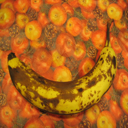

In [55]:
Image.fromarray((inp[17]*255).astype('uint8'),'RGB')

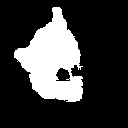

In [56]:
imgpred[17]

In [ ]:
unet.save('/content/drive/MyDrive/Model/train.h5')

In [14]:
unet=load_model('/content/drive/MyDrive/Model/train.h5')

In [57]:
unet.evaluate(inputs,outputs)

2/2 [==============================] - 16s 2s/step - loss: 0.6969 - accuracy: 0.8462


[0.6969045996665955, 0.8462287187576294]